# Iris data set: inference with NN / SVI solution

Import the required Python packages.

In [1]:
import pyro
import numpy
import torch
import sklearn
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn import model_selection
from pyro.infer.mcmc import NUTS, MCMC
import pyro.distributions as pdist
import torch.distributions as tdist
import torch.nn as tnn
import pyro.nn as pnn
import arviz as az
import seaborn as sns

Set some parameters for inference and make reproducible.



In [2]:
seed_value = 42  # Replace with your desired seed value
torch.manual_seed(seed_value)
pyro.set_rng_seed(seed_value)
numpy.random.seed(seed_value)

# MAP or diagonal normal?
MAP=True
if MAP:
  MAXIT=2000 # SVI iterations
  REPORT=200 # Plot ELBO each time after this amount of SVI iterations
else:
  MAXIT=100000
  REPORT=1000

# Number of samples used in prediction
S=500

Function to evaluate the accuracy of our trained model.

In [3]:
def accuracy(pred, data):
  """
  Calculate accuracy of predicted labels (integers).

  pred: predictions, tensor[sample_index, chain_index, data_index, logits]
  data: actual data (digit), tensor[data_index]

  Prediction is taken as most common predicted value.
  Returns accuracy (#correct/#total).
  """
  n=data.shape[0]
  correct=0
  total=0
  for i in range(0, n):
      # Get most common prediction value from logits
      pred_i=int(torch.argmax(torch.sum(pred[:,0,i,:],0)))
      # Compare prediction with data
      if int(data[i])==int(pred_i):
          correct+=1.0
      total+=1.0
  # Return fractional accuracy
  return correct/total

Load the [iris flower data set](https://en.wikipedia.org/wiki/Iris_flower_data_set) set from [scikit-learn](https://sklearn.org/).

In [4]:
# Iris data set
Dx=4 # Input vector dim
Dy=3 # Number of labels

iris=sklearn.datasets.load_iris()
x_all=torch.tensor(iris.data, dtype=torch.float) # Input vector (4D)
y_all=torch.tensor(iris.target, dtype=torch.int) # Label(3 classes)

# Make training and test set
x, x_test, y, y_test = sklearn.model_selection.train_test_split(
    x_all, y_all, test_size=0.33, random_state=42)

print("Data set / test set sizes: %i, %i." % (x.shape[0], x_test.shape[0]))

Data set / test set sizes: 100, 50.


The probabilistic model, implemented as a callable class. We could also simply use a function.


In [5]:
class Model:
    def __init__(self, x_dim=4, y_dim=3, h_dim=5):
        self.x_dim=x_dim
        self.y_dim=y_dim
        self.h_dim=h_dim

    def __call__(self, x, y=None):
        """
        We need None for predictive
        """
        x_dim=self.x_dim
        y_dim=self.y_dim
        h_dim=self.h_dim
        # Number of observations
        n=x.shape[0]
        # standard deviation of Normals
        sd=1 # EXERCISE: 100->1
        # Layer 1
        w1=pyro.sample("w1", pdist.Normal(0, sd).expand([x_dim, h_dim]).to_event(2))
        b1=pyro.sample("b1", pdist.Normal(0, sd).expand([h_dim]).to_event(1))
        # Layer 2 # EXERCISE: added layer
        w2=pyro.sample("w2", pdist.Normal(0, sd).expand([h_dim, h_dim]).to_event(2))
        b2=pyro.sample("b2", pdist.Normal(0, sd).expand([h_dim]).to_event(1))
        # Layer 3
        w3=pyro.sample("w3", pdist.Normal(0, sd).expand([h_dim, y_dim]).to_event(2))
        b3=pyro.sample("b3", pdist.Normal(0, sd).expand([y_dim]).to_event(1))
        # NN
        h1=torch.tanh((x @ w1) + b1)
        h2=torch.tanh((h1 @ w2) + b2) # EXERCISE: added layer
        logits=(h2 @ w3 + b3)
        # Save deterministc variable (logits) in trace
        pyro.deterministic("logits", logits)
        # Categorical likelihood
        with pyro.plate("labels", n):
            obs=pyro.sample("obs", pdist.Categorical(logits=logits), obs=y)

Make the Model and the Guide objects, and optimize the ELBO.  

In [6]:
# Instantiate the Model object
model=Model()

if MAP:
    # MAP estimate of model parameter (here SVI boild down to simple gradient descent)
    guide=pyro.infer.autoguide.AutoDelta(model)
else:
    # Variational estimate of model parameters using diagonal normal (SVI)
    guide=pyro.infer.autoguide.AutoDiagonalNormal(model)

# Optimizer
adam=pyro.optim.Adam({"lr": 0.01})
# SVI
svi=pyro.infer.SVI(model, guide, adam, loss=pyro.infer.Trace_ELBO())

# Clear any previously used parameters
pyro.clear_param_store()

# Optimize the ELBO
elbo=[]
for j in range(0, MAXIT):
    loss=svi.step(x, y)
    elbo.append(loss)
    if j%REPORT==0:
        print("[Iteration %04d] loss: %.4f" % (j, loss))


[Iteration 0000] loss: 188.0556
[Iteration 0200] loss: 88.5219
[Iteration 0400] loss: 87.6917
[Iteration 0600] loss: 87.5678
[Iteration 0800] loss: 87.5448
[Iteration 1000] loss: 87.5417
[Iteration 1200] loss: 87.5420
[Iteration 1400] loss: 87.6410
[Iteration 1600] loss: 87.5408
[Iteration 1800] loss: 87.5406


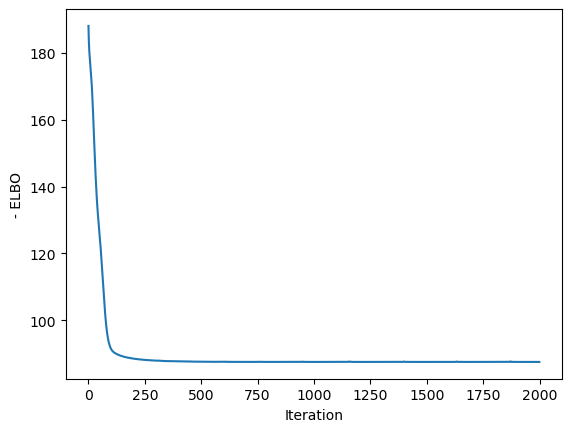

In [7]:
# ELBO vs. iteration plot
plt.xlabel("Iteration")
plt.ylabel("- ELBO")
plt.plot(elbo)

Print the estimated parameters.

In [8]:
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name))

AutoDelta.w1 Parameter containing:
tensor([[-0.2765,  0.2770,  0.1315, -0.0905, -0.0906],
        [-0.5053,  0.5062,  0.2951, -0.3772, -0.3774],
        [ 0.5032, -0.5040, -0.3144,  0.6117,  0.6120],
        [ 0.8447, -0.8461, -0.4528,  0.2644,  0.2644]], requires_grad=True)
AutoDelta.b1 Parameter containing:
tensor([-0.6339,  0.6350,  0.2953, -0.0600, -0.0600], requires_grad=True)
AutoDelta.w2 Parameter containing:
tensor([[ 0.1395,  0.8130, -0.1391, -0.8126,  0.8132],
        [-0.1390, -0.8143,  0.1386,  0.8141, -0.8144],
        [-0.3351, -0.4399,  0.3375,  0.4389, -0.4393],
        [ 0.7146, -0.0385, -0.7144,  0.0384, -0.0385],
        [ 0.7153, -0.0387, -0.7146,  0.0385, -0.0386]], requires_grad=True)
AutoDelta.b2 Parameter containing:
tensor([ 0.1218, -0.1285, -0.1222,  0.1282, -0.1284], requires_grad=True)
AutoDelta.w3 Parameter containing:
tensor([[-1.3203,  0.9797,  0.3405],
        [-0.4262, -0.7263,  1.1524],
        [ 1.3203, -0.9798, -0.3405],
        [ 0.4264,  0.7256, -1

Get the [posterior predictive distribution](https://en.wikipedia.org/wiki/Posterior_predictive_distribution) by sampling the model's parameters from the Guide object and applying the model to the test set.

In [9]:
guide.requires_grad_(False)

posterior_predictive=pyro.infer.Predictive(model, guide=guide, num_samples=S, return_sites=["logits"])(
x_test, None
)

Evaluate the accuracy of the model on the test set.


In [10]:
# Print accuracy
logits=posterior_predictive['logits']
print("Shape of posterior preditive for y (logits):", logits.shape)
print("Success: %.2f" % accuracy(logits, y_test))

Shape of posterior preditive for y (logits): torch.Size([500, 1, 50, 3])
Success: 0.98


# NUTS inferece

In [11]:
# Perform inference using NUTS
# Instantiate the Model object
model=Model()

# NUTS
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_samples=100, warmup_steps=50)
mcmc.run(x, y)

posterior_samples = mcmc.get_samples()

Sample: 100%|████████████████████████████| 150/150 [02:50,  1.13s/it, step size=1.20e-02, acc. prob=0.846]


In [12]:
# Diagnostics from Arviz
nuts_inference = az.from_pyro(mcmc)
nuts_summary = az.summary(nuts_inference, var_names=["w1", "b1", "w2", "b2", "w3", "b3"])

# Print the summary
print("NUTS Summary (R-hat and ESS):")
print(nuts_summary)

arviz - WARNING - Shape validation failed: input_shape: (1, 100), minimum_shape: (chains=2, draws=4)


NUTS Summary (R-hat and ESS):
           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
w1[0, 0]  0.074  0.899  -1.563    2.049      0.161    0.115      35.0   
w1[0, 1] -0.301  0.793  -1.684    1.149      0.147    0.105      29.0   
w1[0, 2]  0.185  0.678  -1.068    1.263      0.373    0.291       4.0   
w1[0, 3] -0.112  1.001  -1.796    1.908      0.163    0.128      37.0   
w1[0, 4]  0.238  0.763  -1.337    1.323      0.159    0.114      25.0   
...         ...    ...     ...      ...        ...      ...       ...   
w3[4, 1] -0.339  1.319  -2.407    2.101      0.179    0.127      54.0   
w3[4, 2] -0.259  1.401  -3.080    2.007      0.307    0.220      21.0   
b3[0]     0.036  0.762  -1.206    1.438      0.086    0.071      84.0   
b3[1]    -0.210  0.908  -2.219    1.062      0.114    0.081      63.0   
b3[2]    -0.008  0.914  -1.650    1.663      0.134    0.095      47.0   

          ess_tail  r_hat  
w1[0, 0]      61.0    NaN  
w1[0, 1]      31.0    NaN  
w1[0, 2] 

In [13]:
# Get posterior predictives (logits) from NUTS
train_predict = pyro.infer.Predictive(model, posterior_samples)(x_test, None)
# Print accuracy
logits=train_predict['logits']
print("Shape of posterior preditive for y (logits):", logits.shape)
print("Success: %.2f" % accuracy(logits, y_test))

Shape of posterior preditive for y (logits): torch.Size([100, 1, 50, 3])
Success: 0.98
